# TensorFlow - Transfer Learning e Fine Tuning
## Eduardo Gomes Sanglard - IAA 2022
### Laboratório de Inteligência Artifical - Frameworks de IA

- Transfer Learning e Fine Tuning: Reconhecer gatos e cachorros


Link para este notebook no Google Colab
https://drive.google.com/file/d/1Zq2ULyVukjWSy630Vy7g6wotT_rwXTRD/view?usp=sharing

In [1]:
import os, zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# plota os gráficos inline e salva no notebook
%matplotlib inline

In [2]:
!wget http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip

--2023-05-01 01:44:03--  http://www.razer.net.br/datasets/cats_and_dogs_filtered.zip
Resolving www.razer.net.br (www.razer.net.br)... 178.128.150.229
Connecting to www.razer.net.br (www.razer.net.br)|178.128.150.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  12.9MB/s    in 6.6s    

2023-05-01 01:44:10 (9.87 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Descompactar a base

In [3]:
dataset_path = "./cats_and_dogs_filtered.zip"
zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [4]:
dataset_path_new = "./cats_and_dogs_filtered"
train_dir = os.path.join(dataset_path_new, "train")
test_dir = os.path.join(dataset_path_new, "validation")

In [5]:
input_shape = (128, 128, 3) # tamanho da imagem entrada
base_model = tf.keras.applications.MobileNetV2(
input_shape=input_shape,include_top=False,weights="imagenet")
base_model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [6]:
# Congelar modelo base
base_model.trainable = False

Adicionar cabeçalho personalizado

In [7]:
print(base_model.output.shape)
# reduzir a dimensionalidade (4 x 4 x 1280 = 20480 pesos para treinar!!)
# Global Average Pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print(global_average_layer.shape)
prediction_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")(
global_average_layer)

(None, 4, 4, 1280)
(None, 1280)


In [8]:
# Definição do modelo (unir o base com o personalizado)
model = tf.keras.models.Model(base_model.input,
prediction_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

Compilar o modelo
Testar com o Adam também

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(
learning_rate=0.0001),
loss="binary_crossentropy",
metrics = ["accuracy"])

Carga das imagens
Pré-processamento /255

In [10]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_test = ImageDataGenerator(rescale=1/255.)

train_generator = data_gen_train.flow_from_directory(train_dir,target_size = (128,128),
                                                     batch_size = 128,
                                                     class_mode = "binary")

test_generator = data_gen_train.flow_from_directory(test_dir,target_size = (128,128),
                                                    batch_size = 128,
                                                    class_mode = "binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# Treinar o modelo
EPOCHS = 5
r = model.fit(train_generator,epochs = EPOCHS,validation_data = test_generator)

Epoch 1/5
16/16 [==============================] - 21s 700ms/step - loss: 0.6362 - accuracy: 0.6320 - val_loss: 0.5772 - val_accuracy: 0.7040
Epoch 2/5
16/16 [==============================] - 9s 580ms/step - loss: 0.5426 - accuracy: 0.7185 - val_loss: 0.5042 - val_accuracy: 0.7650
Epoch 3/5
16/16 [==============================] - 10s 614ms/step - loss: 0.4751 - accuracy: 0.7810 - val_loss: 0.4447 - val_accuracy: 0.8190
Epoch 4/5
16/16 [==============================] - 10s 616ms/step - loss: 0.4201 - accuracy: 0.8290 - val_loss: 0.3953 - val_accuracy: 0.8480
Epoch 5/5
16/16 [==============================] - 9s 545ms/step - loss: 0.3730 - accuracy: 0.8545 - val_loss: 0.3531 - val_accuracy: 0.8660


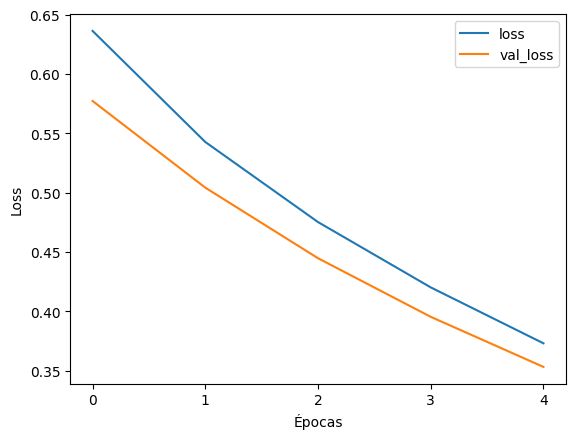

In [12]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

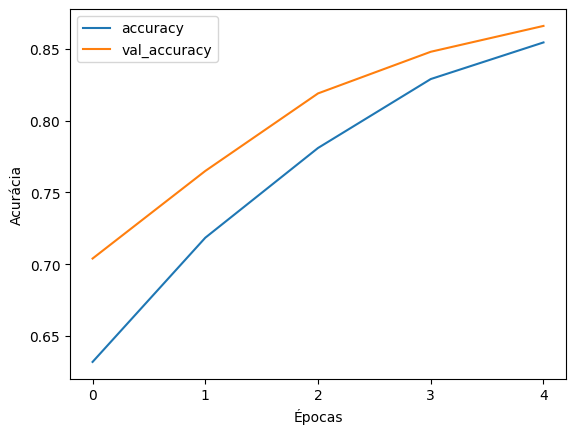

In [13]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

Avaliação do Modelo

In [14]:
val_loss, val_accuracy = model.evaluate (test_generator)
print(val_accuracy)

8/8 [==============================] - 3s 346ms/step - loss: 0.3531 - accuracy: 0.8660
0.8659999966621399


1. Efetuar o Fine Tuning
2. Primeiro fazer o Transfer Learning
3. Depois o Fine Tuning
4. Descongelar algumas camadas

In [15]:
base_model.trainable = True
len(base_model.layers)
# deixar o início da base
# congelar o final
fine_tuning_at = 100
for l in base_model.layers[:fine_tuning_at]:
  l.trainable = False

- Compilar o modelo
- Testar com o Adam tb
- Treinar o modelo

In [16]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])
EPOCHS = 5
r = model.fit(train_generator,
epochs = EPOCHS,
validation_data = test_generator)

Epoch 1/5
16/16 [==============================] - 22s 689ms/step - loss: 0.1981 - accuracy: 0.9210 - val_loss: 0.0843 - val_accuracy: 0.9690
Epoch 2/5
16/16 [==============================] - 9s 585ms/step - loss: 0.0359 - accuracy: 0.9960 - val_loss: 0.0938 - val_accuracy: 0.9720
Epoch 3/5
16/16 [==============================] - 9s 535ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9740
Epoch 4/5
16/16 [==============================] - 9s 548ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1082 - val_accuracy: 0.9720
Epoch 5/5
16/16 [==============================] - 9s 593ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.1248 - val_accuracy: 0.9720


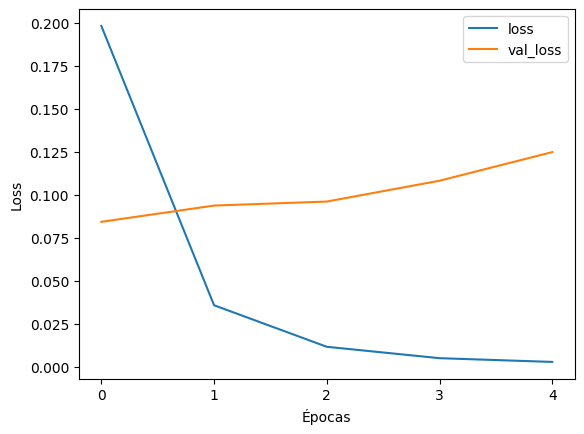

In [17]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()

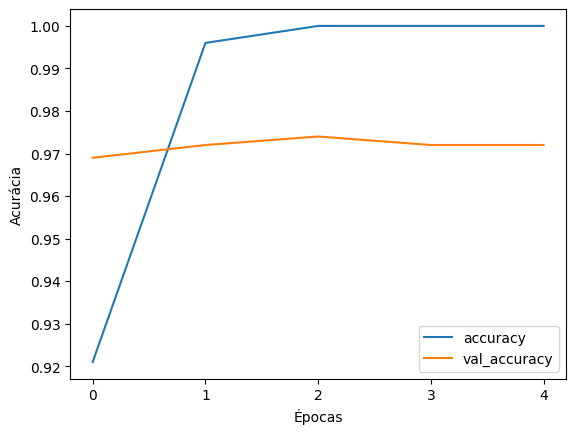

In [18]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.xticks( np.arange(0, EPOCHS, step=1) )
plt.legend()


Avaliação do Modelo

In [ ]:
val_loss, val_accuracy = model.evaluate(test_generator)
print(val_accuracy)